In [27]:
import torch
import matplotlib.pyplot as plt

from network.network import RNNModel
from trajectory_generator import TrajectoryGenerator
from utils.make_train_data import make_train_data

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate test data

In [63]:
# define parameters
T = 20  # duration of simulated trajectories (seconds)
srate = 50  # sampling rate (Hz)

border_region = 0.03  # max. distance to wall (m)
sequence_length = T * srate  # number of steps in trajectory
box_width = 2.2       # width of training environment (m)
box_height = 2.2      # height of training environment (m)
n_data_test = 32 * 60

In [64]:
# generate test data
trajectory_generator = TrajectoryGenerator(sequence_length, border_region, box_width, box_height, n_data_test)
position, velocity, head_dir = trajectory_generator.generate_trajectory()
test = make_train_data(velocity, head_dir)

### Run model on test data

In [79]:
# load model
hidden_size = 256
mini_batch_size = 32
rnn_layer = 'custom'
rnn_model = torch.load(f'models/RNN-{hidden_size}-{rnn_layer}-model.pt')
# rnn_model = RNNModel(hidden_size, mini_batch_size, rnn_layer)
# rnn_model.double()
# rnn_model.load_state_dict(torch.load(f'models/RNN-{hidden_size}-{rnn_layer}-model.pt', map_location=torch.device('cpu')))

rnn_model.eval()
aggregate_loss, y_pred, x = rnn_model.evaluate(test, position)

Start evaluation run: 
............................................................

Aggregated loss: 0.44561247260012166  56.06 seconds for this run 



### Plot trajectories

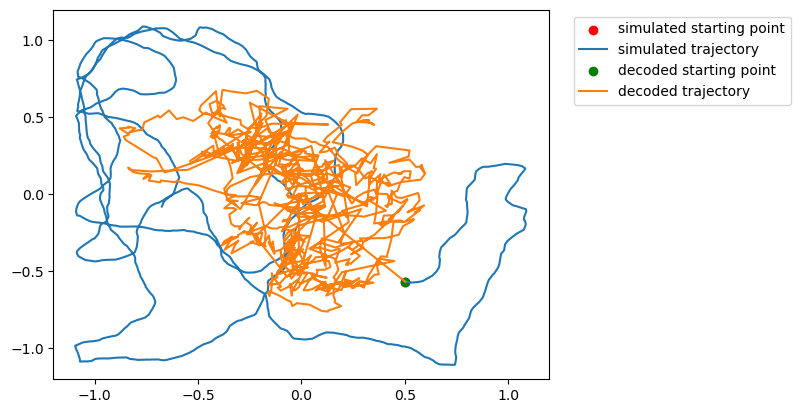

In [81]:
# plot trajectories generated from the network (on test data)
traj_idx = 12
plt.scatter(position[traj_idx, 0, 0], position[traj_idx, 0, 1], color = 'red', label = 'simulated starting point')
plt.plot(position[traj_idx, :, 0], position[traj_idx, :, 1], label = 'simulated trajectory')

plt.scatter(y_pred[traj_idx, 0, 0], y_pred[traj_idx, 0, 1], color = 'green', label = 'decoded starting point')
plt.plot(y_pred[traj_idx, :, 0], y_pred[traj_idx, :, 1], label = 'decoded trajectory')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.legend(bbox_to_anchor=(1.5, 1.))

plt.savefig('trajectory.png', bbox_inches='tight')
# plt.show()